In [1]:
#import packages
import math
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('Agmarknet_Price_Report.csv')

#print the head
df.head()

,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date
0,1,Agra,Achnera,Potato,Desi,FAQ,780,870,825,30-Mar-22
1,2,Agra,Achnera,Potato,Desi,FAQ,800,880,840,29-Mar-22
2,3,Agra,Achnera,Potato,Desi,FAQ,830,930,880,28-Mar-22
3,4,Agra,Achnera,Potato,Desi,FAQ,820,920,870,27-Mar-22
4,5,Agra,Achnera,Potato,Desi,FAQ,860,940,900,26-Mar-22


In [2]:
months = {'Jan':'01',"Feb":"02","Mar":"03","Apr":"04","May":"05","Jun":"06","Jul":"07","Aug":"08","Sep":"09","Oct":"10","Nov":"11","Dec":"12"}
def change_to_date(data):
    date = data.split("-")
    year = "20"+ date[2]
    month =  months[date[1]]
    day = date[0]
    return"-".join([year,month,day])

In [3]:
df['Date'] = df['Price Date'].apply(change_to_date)

In [4]:
df.head()

,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,Date
0,1,Agra,Achnera,Potato,Desi,FAQ,780,870,825,30-Mar-22,2022-03-30
1,2,Agra,Achnera,Potato,Desi,FAQ,800,880,840,29-Mar-22,2022-03-29
2,3,Agra,Achnera,Potato,Desi,FAQ,830,930,880,28-Mar-22,2022-03-28
3,4,Agra,Achnera,Potato,Desi,FAQ,820,920,870,27-Mar-22,2022-03-27
4,5,Agra,Achnera,Potato,Desi,FAQ,860,940,900,26-Mar-22,2022-03-26


In [5]:
df.drop(['Price Date','Grade','Commodity','District Name','Sl no.'], axis = 1, inplace = True)

In [6]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

In [7]:
df

,Market Name,Variety,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Date
Date,,,,,,
2022-03-30,Achnera,Desi,780,870,825,2022-03-30
2022-03-29,Achnera,Desi,800,880,840,2022-03-29
2022-03-28,Achnera,Desi,830,930,880,2022-03-28
2022-03-27,Achnera,Desi,820,920,870,2022-03-27
2022-03-26,Achnera,Desi,860,940,900,2022-03-26
...,...,...,...,...,...,...
2014-08-30,Samsabad,Other,1800,1880,1840,2014-08-30
2014-07-31,Samsabad,Other,1580,1799,1600,2014-07-31
2014-06-30,Samsabad,Other,0,0,1500,2014-06-30


In [8]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Modal Price (Rs./Quintal)'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Modal Price (Rs./Quintal)'][i] = data['Modal Price (Rs./Quintal)'][i]
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

# NOTE: While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. So here we have set the last year’s data into validation and the 4 years’ data before that into train set.
train_size = math.ceil((df.shape[0])*0.8)
valid_size = math.floor((df.shape[0])*0.2)
# splitting into train and validation
train = new_data[:train_size]
valid = new_data[train_size:]

#creating train and test sets
dataset = new_data.values

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

11785/11785 - 190s - loss: 2.5077e-04 - 190s/epoch - 16ms/step


In [10]:
rms=np.sqrt(np.mean(np.power((valid-predicted_price),2)))
rms

Modal Price (Rs./Quintal)    236.754064
dtype: float64

<ipython-input-11-c0b300bd5deb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_price


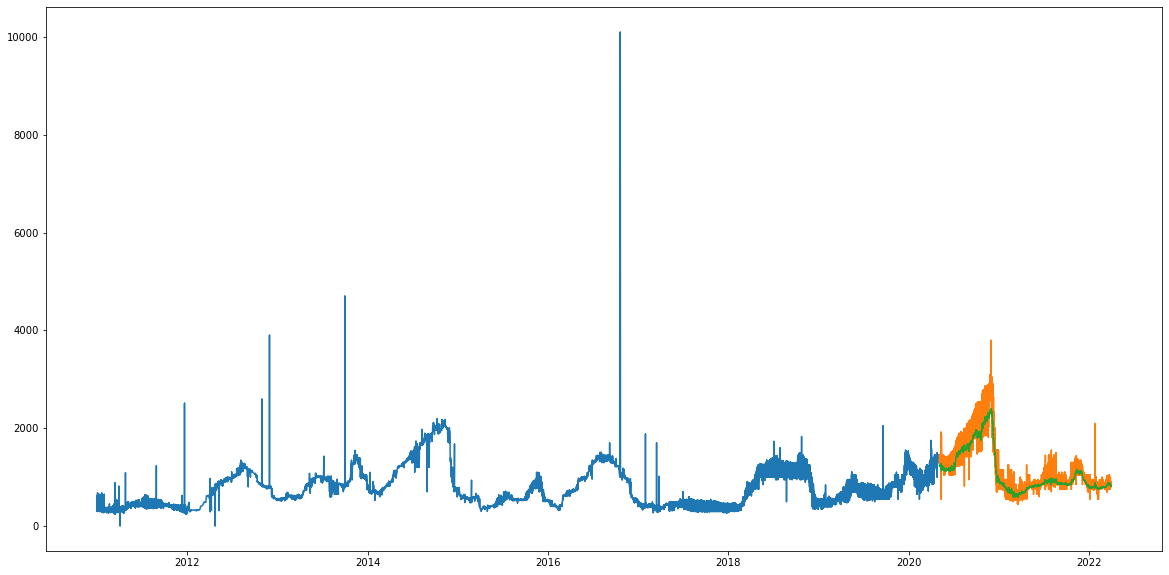

In [11]:
#for plotting
train = new_data[:train_size]
valid = new_data[train_size:]
valid['Predictions'] = predicted_price
plt.plot(train['Modal Price (Rs./Quintal)'])
plt.plot(valid[['Modal Price (Rs./Quintal)','Predictions']])